Name: Gajaanan S.
Index No: 190185D

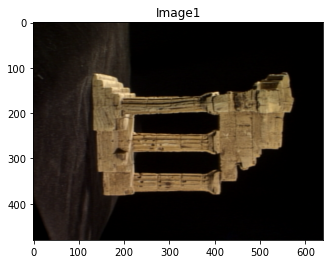

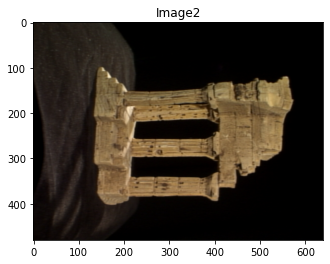

P1 = [[ 4.80251845e+01  1.44011271e+03 -5.71648932e+02  7.53293366e+01]
 [ 1.53577034e+03 -6.41434324e+01 -1.63127843e+02  1.85810055e+02]
 [ 4.88387837e-02 -1.81568392e-01 -9.82164799e-01  6.14604846e-01]]
P2 = [[-1.55882371e+02  1.44377186e+03 -5.42436214e+02  6.81806220e+01]
 [ 1.34928131e+03 -8.41979541e+01 -7.49443961e+02  1.99929996e+02]
 [-3.40999743e-01 -1.74474039e-01 -9.23730472e-01  6.00850565e-01]]


In [18]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.linalg import null_space
f = open('templeSR_par.txt')
assert f is not None
n = int(f.readline())

#Read the information of the first image

l = f.readline().split()
im1_fn = l[0]

K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

#Read the information of the second image

l = f.readline().split()
im2_fn = l[0]

K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

#Read the 2 image and show

im1 = cv.imread(r'./templeSparseRing/' + im1_fn ,cv.IMREAD_COLOR)
im2 = cv.imread(r'./templeSparseRing/' + im2_fn ,cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None
#cv.namedWindow('Im')
#cv.imshow('Im',im1)
#cv.waitKey(0)
#cv.imshow('Im',im2)
#cv.waitKey(0)
#cv.destroyAllWindows()
im1 = cv.cvtColor(im1, cv.COLOR_BGR2RGB)
im2 = cv.cvtColor(im2, cv.COLOR_BGR2RGB)
plt.imshow(im1)
plt.title('Image1')
plt.show()
plt.imshow(im2)
plt.title('Image2')
plt.show()

#Compute P1 and P2

P1 = K1 @ np.hstack((R1,t1)) # P = K*[R|t]
P2 = K2 @ np.hstack((R2,t2)) # P = K*[R|t]
print('P1 =',P1)
print('P2 =',P2)

F = [[-2.87071497e-04 -3.96261289e-02  2.94221686e+02]
 [-3.55039713e-02  1.65329260e-04  1.78860854e+01]
 [-2.76702814e+02  2.12942175e+01 -9.06669374e+03]]


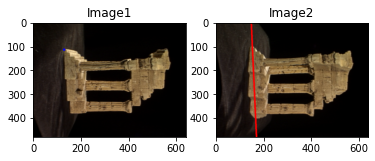

In [22]:
#Compute F

def skew(x):
    x=x.ravel()
    return np.array([[0,-x[2],x[1]],[x[2],0,-x[0]],[-x[1],x[0],0]])
C = null_space(P1)
C = C * np.sign(C[0,0])
e2 = P2 @ C
e2x = skew(e2)
F = e2x @P2 @ np.linalg.pinv(P1)
print('F =',F)

#Compute the epipolar line corresponding to the given x and plot

x = np.array([130,115,1])
cv.circle(im1,(x[0],x[1]),5,(0,0,255),-1)
l2 = F @ x.T
p1 = np.array([0,(l2[0]*0 + l2[2])/l2[1]]).astype(int)
p2 = np.array([500,(l2[0]*500+l2[2])/l2[1]]).astype(int)
cv.line(im2,(p1[0],p1[1]),(p2[0],p2[1]),(255,0,0),5)
#cv.namedWindow('Im')
#cv.imshow('Im',im1)
#cv.waitKey(0)
#cv.imshow('Im',im2)
#cv.waitKey(0)
#cv.destroyAllWindows()
plt.subplot(121)
plt.imshow(im1)
plt.title('Image1')
plt.subplot(122)
plt.imshow(im2)
plt.title('Image2')
plt.show()

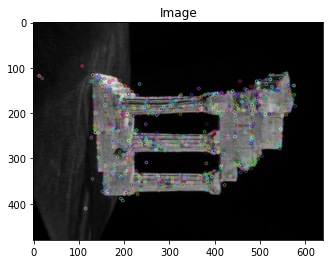

In [26]:
gray= cv.cvtColor(im1,cv.COLOR_RGB2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,im1)
plt.imshow(im1)
plt.title('Image')
plt.show()

In [15]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img1 = cv.imread('templeSR0001.png',0)  
img2 = cv.imread('templeSR0002.png',0) 
sift = cv.SIFT_create()

kp1,des1 = sift.detectAndCompute(img1,None)
kp2,des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]


In [16]:
def drawlines(img1,img2,lines,pts1,pts2):

    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

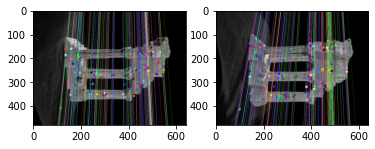

In [17]:
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()